# Regressió amb Xarxes Neuronals (ANN)
La idea d'utilitzar aquest dataset ha sorgit degut a que un amic meu ha fet un  model de regressió a mà (utilitzant numpy per a multiplicar vectors i matrius) per a calcular el preu d'un apartament de lloguer segons la quantitat d'habitacions, banys, metres quadrats i districte. El dataset l'ha extret utilitzant WebScraper i ha obtingut unes 15000 mostres. <br>
He aprofitat que ha formatejat el dataset. L'única modificació que he fet ha sigut en relació amb el districte, que està en format "bucketized" (totes les columnes són un 0 menys el districte corresponent que és un 1) excepte que ell tracta quan tots són 0 correspon a Sarrià, així que he afegit una columna extra assignant-li el 1 corresponent. <br>
Enllaç al seu repositori: https://github.com/aayzaa/barcelona_rental_prices_predictor

In [ ]:
!pip install -U tensorflow-addons

import pandas as pd

try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

url = "https://raw.githubusercontent.com/dcumelles7e3/dsets/main/barcelona_apartments.csv"

req = Request(url)
req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
content = urlopen(req)

data = pd.read_csv(content)
print(data.head())
print(data.shape)

     |████████████████████████████████| 706kB 4.1MB/s 
   price  rooms  bathrooms  ...  sant_marti  sants_montjuic  sarria
0   1250      2          2  ...           0               0       0
1   1450      3          1  ...           0               0       0
2    800      2          1  ...           0               0       0
3   1050      3          1  ...           0               0       0
4   1375      2          1  ...           0               0       1

[5 rows x 14 columns]
(14859, 14)


# Preparar les dades de Test i Train
Fem una llista amb les categories per a millor visualització.


In [ ]:
districts = ["eixample", "ciutat_vella", "horta_guinardo", "gracia", "les_corts", "nou_barris", "sant_andreu",
             "sant_marti", "sants_montjuic", "sarria"]
features = ["rooms", "bathrooms", "sizem2"]
feature_columns = []
for feature in features:
    feature_columns.append(feature)

for district in districts:
    feature_columns.append(district)

print(feature_columns)

['rooms', 'bathrooms', 'sizem2', 'eixample', 'ciutat_vella', 'horta_guinardo', 'gracia', 'les_corts', 'nou_barris', 'sant_andreu', 'sant_marti', 'sants_montjuic', 'sarria']


Test i Train

In [ ]:
train = data.sample(frac=0.8, random_state=2021)
test = data.drop(train.index)

X_train = train.loc[:, feature_columns]
X_test = test.loc[:, feature_columns]
y_train = train["price"]
y_test = test["price"]

He comprovat que obtinc millor resultat si normalitzo les dades: 0.58 sense normalitzar // 0.60 normalitzant.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras

normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

# Preparar el model
A l'hora de preparar el model hem d'escollir la quantitat de capes ocultes i les seves funcions d'activació, la última capa sent la funció de regressió RSquare del Tensorflow Addons.<br>


Després de fer proves, he decidit que el learning rate de l'optimizer Adam ha de ser 0.001 i amb el loss "mean_squared_error" em dona 0.02 més que amb "mean_absolute".

| Model | Score (*) Training | Score (*) Test |
| - | :-: | :-: |
| <li>2x Dense 128</li> | 0.64 | 0.61 |
| <li>2x Dense 256</li> | 0.62 | 0.59 |
| <li>1x Dense 64</li><li>2x Dense 128</li> | 0.64 | 0.62 |




In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss="mean_squared_error",
              metrics=tfa.metrics.RSquare(y_shape=(1,)))

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)


val_loss, val_acc = model.evaluate(X_train, y_train)
print(val_loss, val_acc)
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss, val_acc)

Epoch 1/100
298/298 [==============================] - 2s 3ms/step - loss: 2041023.9055 - r_square: -0.6793 - val_loss: 451007.9062 - val_r_square: 0.5794
Epoch 2/100
298/298 [==============================] - 1s 2ms/step - loss: 420243.6128 - r_square: 0.5992 - val_loss: 450723.2500 - val_r_square: 0.5797
Epoch 3/100
298/298 [==============================] - 1s 2ms/step - loss: 401533.7792 - r_square: 0.5998 - val_loss: 453312.3125 - val_r_square: 0.5772
Epoch 4/100
298/298 [==============================] - 1s 2ms/step - loss: 396431.9560 - r_square: 0.6050 - val_loss: 446959.2812 - val_r_square: 0.5832
Epoch 5/100
298/298 [==============================] - 1s 2ms/step - loss: 415071.8164 - r_square: 0.6572 - val_loss: 445732.5938 - val_r_square: 0.5843
Epoch 6/100
298/298 [==============================] - 1s 2ms/step - loss: 406557.4416 - r_square: 0.6283 - val_loss: 445667.5938 - val_r_square: 0.5844
Epoch 7/100
298/298 [==============================] - 1s 2ms/step - loss: 37933

He fet 100 epochs al Colab per a que no trigui tant la sortida, però crec que no calen més de 400, ja que la millora és poca.

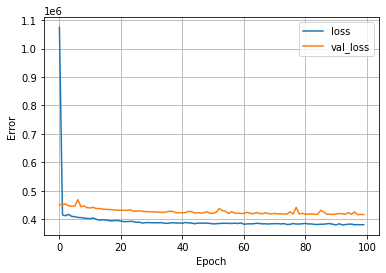

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    if history.history.get('val_loss'):
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

# Conclusió i next steps
Amb una puntuació d'entre 0.65 ~ 0.70 el model és acceptable. <br>
El següent pas seria guardar el model i programar una interfície on demanem les dades d'un apartament i li passem al model per a predir el preu.

# Webgrafia
* https://github.com/aayzaa/barcelona_rental_prices_predictor - Repositori de referència.
* https://www.tensorflow.org/tutorials/structured_data/feature_columns - Informació sobre bucketized columns.

* https://www.tensorflow.org/tutorials/keras/save_and_load - Informació de com guardar i carregar el model.


